<a href="https://colab.research.google.com/github/Anspire/Notebooks/blob/master/Transfer_learning_based_classifier_to_classify_benign_malignant_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists, join, basename

## Tensorflor imports
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import ResNet50, VGG16, MobileNetV2, NASNetMobile
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout

## get current working directory
cwd = os.getcwd()

## Dataset
As with any deep learning task, the first most important task is to prepare the dataset.

Download [warwick_qu_dataset](https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip)

In [3]:
dataset_name = join(cwd, 'warwick_qu_dataset_released_2016_07_08')
if not exists(dataset_name + '.zip'):
  get_ipython().system('wget https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip')

--2019-09-14 08:17:17--  https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 180902609 (173M) [application/zip]
Saving to: ‘warwick_qu_dataset_released_2016_07_08.zip’

warwick_qu_dataset_ 100%[===================>] 172.52M  11.9MB/s    in 28s     

2019-09-14 08:17:46 (6.13 MB/s) - ‘warwick_qu_dataset_released_2016_07_08.zip’ saved [180902609/180902609]



### Unzip dataset

In [0]:
dataset_dir = join(cwd, 'Warwick QU Dataset (Released 2016_07_08)')
if not exists(dataset_dir):
  get_ipython().system('unzip ' + dataset_name + '.zip')

##Data Preprocessing
Read and clean csv file 

In [6]:
data = pd.read_csv(join(dataset_dir, 'Grade.csv')) 
data = data.rename(columns={data.columns[2]: 'label'})
data = data[['name', 'label']]
data['name'] = [name + '.bmp' for name in data['name']]
data.head()

,name,label
0,testA_1.bmp,benign
1,testA_10.bmp,benign
2,testA_11.bmp,benign
3,testA_12.bmp,malignant
4,testA_13.bmp,malignant


 Let's take a look at a few pictures of every category to get a better sense of what they look like:

[' benign', ' malignant']


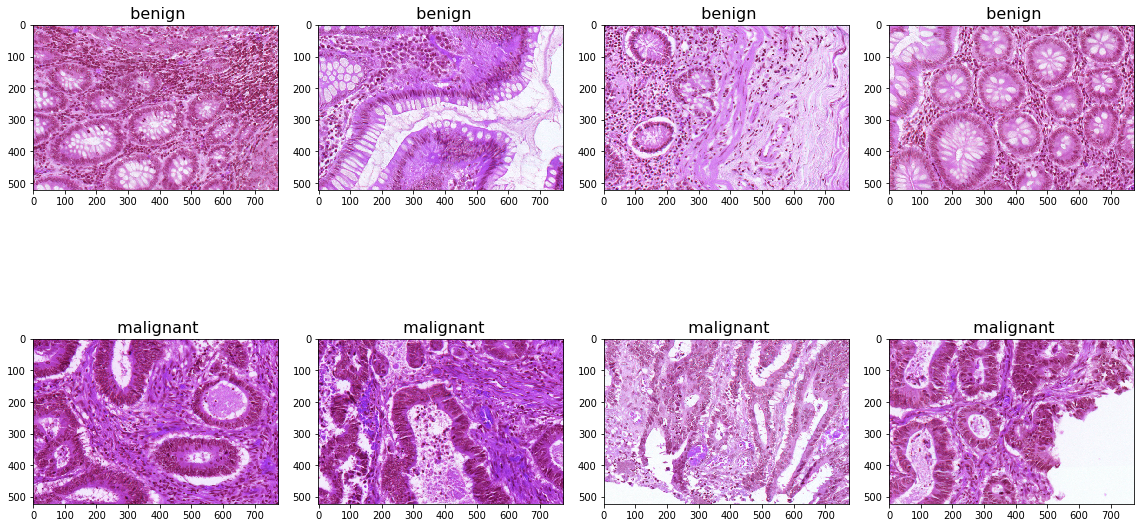

In [7]:
class ImageViewer:
    def read_img(self,id):
        """
        Read image by it's id
        """
        file = dataset_dir + '/' + str(id)
        im=cv2.imread(file)
        return im

    def draw_sample_images(self):
        """
        Draw malignant and healthy benign for EDA
        """
        ncols=4
        f, ax = plt.subplots(nrows=2,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions = list(set(data['label']))
        # Draw one row for malignant, one row for benign images
        for label in captions:
            i=i+1
            samples = data[data['label']==label]['name'].sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()
    
ImageViewer().draw_sample_images()

Quick EDA (Exploratory Data Analysis)

In [0]:
def eda(df):
  df.label.value_counts().plot(kind='bar')
  plt.title('Labels counts')
  plt.xlabel('Label')
  plt.ylabel('Count')
  plt.show()

### Split dataset in train, validation and test set

(85, 2)


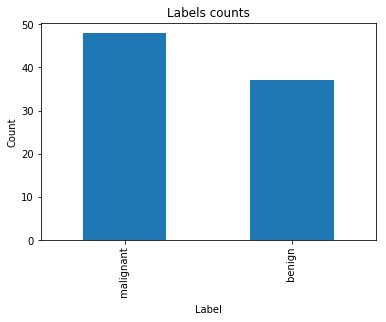

,name,label
80,train_1.bmp,malignant
81,train_10.bmp,malignant
82,train_11.bmp,malignant
83,train_12.bmp,benign
84,train_13.bmp,malignant


In [9]:
train_df = data[data.name.str.startswith('train')]
print('Number of training example :', train_df.shape[0])
eda(train_df)
train_df.head()

(60, 2)


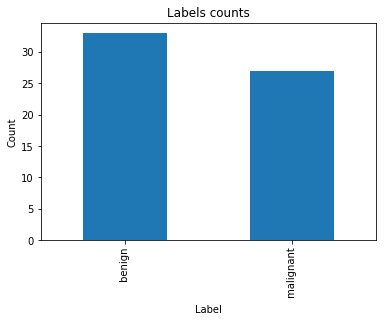

,name,label
0,testA_1.bmp,benign
1,testA_10.bmp,benign
2,testA_11.bmp,benign
3,testA_12.bmp,malignant
4,testA_13.bmp,malignant


In [10]:
valid_df = data[data.name.str.startswith('testA')]
print('Number of validation example :', valid_df.shape[0])
eda(valid_df)
valid_df.head()

(20, 2)


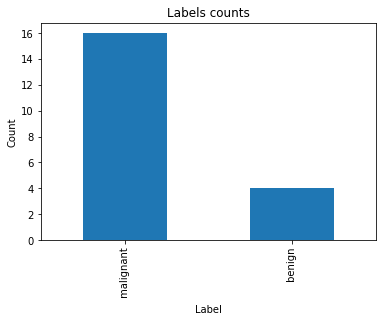

,name,label
60,testB_1.bmp,malignant
61,testB_10.bmp,malignant
62,testB_11.bmp,malignant
63,testB_12.bmp,malignant
64,testB_13.bmp,malignant


In [11]:
test_df = data[data.name.str.startswith('testB')]
print('Number of test example :', test_df.shape[0])
eda(test_df)
test_df.head()

## DataGenerator

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory).

In [12]:
image_size = 224
train_datagen=ImageDataGenerator(rescale=1./255,
                                 featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 rotation_range=90,
                                 zoom_range=0.15, 
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.15,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              shuffle = True,
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

valid_generator = test_datagen.flow_from_dataframe(dataframe = valid_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              shuffle = True,
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                              directory = dataset_dir,
                                              x_col = "name",
                                              y_col = 'label',
                                              class_mode = "binary",
                                              target_size = (image_size,image_size),
                                              batch_size = 16)

Found 85 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


## Building Model

In [13]:
model = Sequential()

model.add(MobileNetV2(input_shape= (image_size, image_size, 3), include_top=False, pooling='avg'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
9412608/9406464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,575,873
Trainable params: 1,315,329
Non-trainable params:

Configure the specifications for model training.Train model with the **binary_crossentropy** loss, because it's a multi-class classification problem and final activation is a **sigmoid**.

In [14]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

Let's train for 30 epochs

In [15]:
epochs = 30

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = epochs)

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 0.8203 - acc: 0.5797 - val_loss: 0.7452 - val_acc: 0.4792
Epoch 2/50
5/5 [==============================] - 1s 252ms/step - loss: 0.4608 - acc: 0.7875 - val_loss: 0.6779 - val_acc: 0.5417
Epoch 3/50
5/5 [==============================] - 1s 201ms/step - loss: 0.4803 - acc: 0.7586 - val_loss: 0.6952 - val_acc: 0.5833
Epoch 4/50
5/5 [==============================] - 1s 251ms/step - loss: 0.3303 - acc: 0.9125 - val_loss: 0.6509 - val_acc: 0.6458
Epoch 5/50
5/5 [==============================] - 1s 195ms/step - loss: 0.3255 - acc: 0.8621 - val_loss: 0.5928 - val_acc: 0.7917
Epoch 6/50
5/5 [==============================] - 1s 255ms/step - loss: 0.3547 - acc: 0.8125 - val_loss: 0.6004 - val_acc: 0.7500
Epoch 7/50
5/5 [==============================] - 1s 233ms/step - loss: 0.2149 - acc: 0.9710 - val_loss: 0.5690 - val_acc: 0.7500
Epoch 8/50
5/5 [==============================] - 1s 257ms/step - loss: 0.2779 - acc: 0.9250 

## Visualize Training/Validation Loss/Accuracy

In [0]:
def plot_history(history):
  """
  Plot training history
        """
  ## Trained model analysis and evaluation
  f, ax = plt.subplots(1,2, figsize=(12,3))
  ax[0].plot(history.history['loss'], label="Loss")
  ax[0].plot(history.history['val_loss'], label="Validation loss")
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  # Accuracy
  ax[1].plot(history.history['acc'], label="Accuracy")
  ax[1].plot(history.history['val_acc'], label="Validation accuracy")
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  plt.tight_layout()
  plt.show()

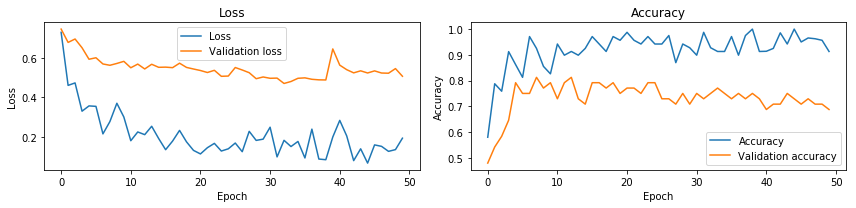

In [17]:
plot_history(history)

## Evaluate model

In [0]:
metrics_names = model.metrics_names
metrics = model.evaluate_generator(test_generator)

print(metrics_names[0] + ' = ', metrics[0])
print(metrics_names[1] + ' = ', metrics[1])